# 3.1: Adaptive minimum-variance portfolio optimisation

### Q3.1.1: Derive the optimal weights to construct the minimum variance portfolio. Then derive the theoretical variance of your returns if you were to apply these weights.

#### Minimum-Variance Portfolio Optimization

We solve the constrained optimization problem:

$$
\min_{\mathbf w} \; \frac{1}{2}\mathbf w^T C \mathbf w
\quad \text{subject to} \quad
\mathbf w^T \mathbf 1 = 1
$$

#### Lagrangian

$$
\mathcal{L}(\mathbf w, \lambda)
=
\frac{1}{2}\mathbf w^T C \mathbf w
-
\lambda (\mathbf w^T \mathbf 1 - 1)
$$

#### First-Order Condition

Taking the gradient with respect to $\mathbf w$:

$$
\nabla_{\mathbf w} \mathcal{L}
=
C \mathbf w - \lambda \mathbf 1 = 0
$$

$$
C \mathbf w = \lambda \mathbf 1
$$

Assuming $C$ is invertible:

$$
\mathbf w = \lambda C^{-1} \mathbf 1
$$

#### Enforcing the Constraint

$$
\mathbf w^T \mathbf 1 = 1
$$

$$
(\lambda C^{-1} \mathbf 1)^T \mathbf 1 = 1
$$

$$
\lambda \mathbf 1^T C^{-1} \mathbf 1 = 1
$$

$$
\lambda = \frac{1}{\mathbf 1^T C^{-1} \mathbf 1}
$$

#### Optimal Minimum-Variance Weights

$$
\mathbf w^*
=
\frac{C^{-1}\mathbf 1}
{\mathbf 1^T C^{-1} \mathbf 1}
$$

#### Theoretical Minimum Variance

Portfolio variance:

$$
\sigma^2 = \mathbf w^T C \mathbf w
$$

Substitute $\mathbf w^*$:

$$
\sigma_{\min}^2
=
\frac{1}
{\mathbf 1^T C^{-1} \mathbf 1}
$$

#### Final Results

$$
\mathbf w^* = \dfrac{C^{-1}\mathbf 1}{\mathbf 1^T C^{-1} \mathbf 1}
$$

$$
\sigma_{\min}^2 = \dfrac{1}{\mathbf 1^T C^{-1} \mathbf 1}
$$



### Q3.1.2: Download data for 10 stocks, and split 50/50 into training and test sets. Find the optimal weights for the training set, and compare the performance when applied to the testing set. Measure the portfolio variance and cumulative return over a time horizon of T days.

Training:
Optimal Weights: [ 0.07175548  0.08236719 -0.00137305  0.17670994 -0.02748727  0.05642944
  0.2390134   0.14010888  0.21003307  0.05244292]
Theoretical Minimum Variance: 2.8616294052082798e-05

Testing:
Portfolio Variance: 8.191995803752641e-05
Cumulative Return: -0.11758175254048275


/var/folders/qb/hgghhgfj3x3ds_w9zrv3v0jm0000gn/T/ipykernel_66501/3479784601.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Stocks', bbox_to_anchor=(1.05, 1), loc='upper left')


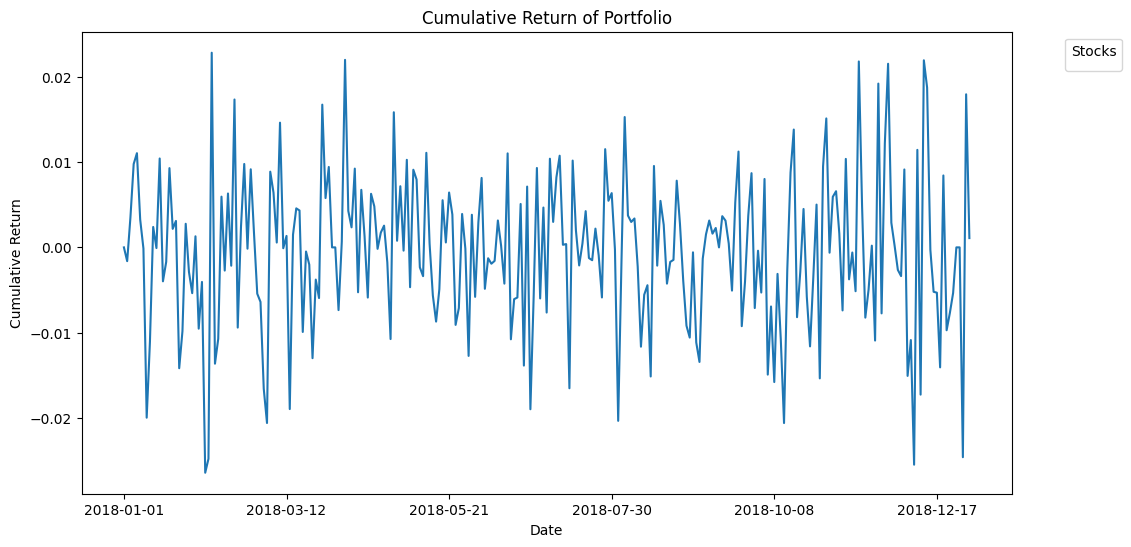

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

TRAINING_PROPORTION = 0.5
daily_returns = pd.read_csv('fsp_case_31_BSD.csv', index_col=0, header=[0, 1])["ret"]
r_t = daily_returns[daily_returns.columns[-10:]]

training = r_t.iloc[:int(len(r_t) * TRAINING_PROPORTION)]
testing = r_t.iloc[int(len(r_t) * TRAINING_PROPORTION):]


# Training: find optimal weights and theoretical minimum variance
mu = training.mean()
C = training.cov()

w_optimal = np.linalg.inv(C) @ np.ones(len(mu)) / (np.ones(len(mu)).T @ np.linalg.inv(C) @ np.ones(len(mu)))
var_min = 1 / (np.ones(len(mu)).T @ np.linalg.inv(C) @ np.ones(len(mu)))

print("Training:")
print("Optimal Weights:", w_optimal)
print("Theoretical Minimum Variance:", var_min)
print("")

# Testing: apply optimal weights to testing set and calculate portfolio variance and cumulative return
portfolio_variance = w_optimal.T @ testing.cov() @ w_optimal
cumulative_return_t = (testing @ w_optimal)
cumulative_return = cumulative_return_t.sum()
return_variance = cumulative_return_t.var()

print("Testing:")
print("Portfolio Variance:", portfolio_variance)
print("Cumulative Return:", cumulative_return)

# plot cumulative return
cumulative_return_t.plot(figsize=(12, 6))
plt.title('Cumulative Return of Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(title='Stocks', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



The theoretical minimum variance given the optimal weights and the covariance matrix of the training portfolio is `2.8616294052082798e-05`.
The actual variance we see in the testing set is `8.191995803752641e-05`.
The variance of the returns of the test portfolio are higher (which is to be expected since we did not optimise for this portfolio) but still similar to the theoretical minimum.

### Q3.1.3: Implement the adaptive time-varying minimum variance portfolio using the estimate of the mean and covariance matrix using a rolling window of length M days. Compare the performance of this strategy to that of Part 2. Elaborate on whether there exists a different method to compute the sample covariance matrix.

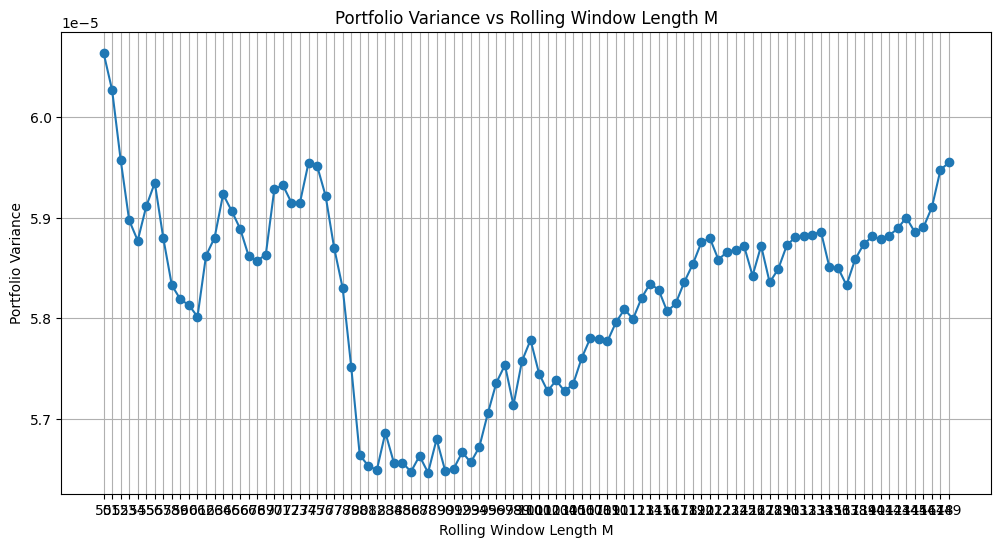

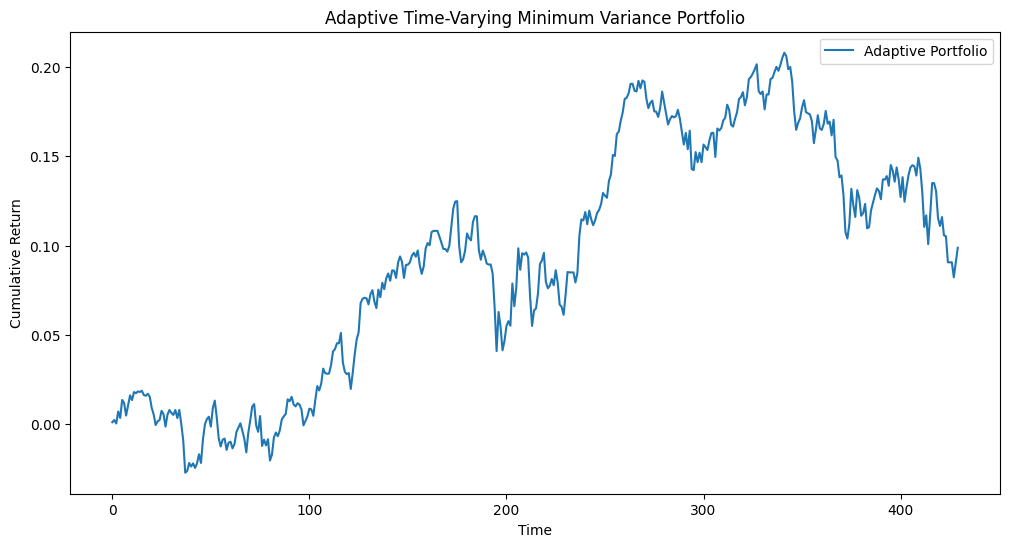

Adaptive Portfolio Variance: 5.6482576270970395e-05
Adaptive Portfolio Final Return: 0.09872083139828333


In [56]:
# Parameters
M = 100  # Rolling window length

returns = pd.concat([training, testing])

def run_adaptive_portfolio(returns, M):
    portfolio_returns = []
    for t in range(M, len(returns)-1):
        window = returns.iloc[t-M:t]
        C_t = window.cov()
        
        w_t = np.linalg.inv(C_t) @ np.ones(len(window.columns))
        w_t = w_t / (np.ones(len(window.columns)).T @ np.linalg.inv(C_t) @ np.ones(len(window.columns)))
        
        next_return = returns.iloc[t+1]
        portfolio_return = next_return @ w_t
        portfolio_returns.append(portfolio_return)

    return portfolio_returns

portfolio_variances = []
for m in range(50, 150, 1):
    portfolio_returns = run_adaptive_portfolio(returns, m)
    portfolio_variance = np.var(portfolio_returns)
    portfolio_variances.append(portfolio_variance)

# plot variances
plt.figure(figsize=(12, 6))
plt.plot(range(50, 150, 1), portfolio_variances, marker='o')
plt.title('Portfolio Variance vs Rolling Window Length M')
plt.xlabel('Rolling Window Length M')
plt.ylabel('Portfolio Variance')
plt.xticks(range(50, 150, 1))
plt.grid()
plt.show()

# Plot cum returns for best M
best_M = 90
adaptive_returns = run_adaptive_portfolio(returns, best_M)
adaptive_cumulative_returns = np.cumsum(adaptive_returns)
portfolio_variance = np.var(adaptive_returns)

# Plot adaptive cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(adaptive_cumulative_returns, label='Adaptive Portfolio')
plt.title('Adaptive Time-Varying Minimum Variance Portfolio')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

print("Adaptive Portfolio Variance:", portfolio_variance)
print("Adaptive Portfolio Final Return:", adaptive_cumulative_returns[-1])

When using a window of 90 earlier days as a sample, the adaptive model had a portfolio variance of `5.6482576270970395e-05`, closer to the theoretical minimum of `2.8616294052082798e-05` computed in part 1.

Some alternative models to the time-adaptive model provided include:
- Exponentially Weighted Covariance: giving decaying weights to older data in the window.
- Shrinkage Estimators: aim to pull the covariance matrix towards a structured target like an Identity matrix.